<a href="https://colab.research.google.com/github/descandon88/Economics-Complexity/blob/main/1_netviz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Visualize the space as a network

In this section, we will practice how to visualize the X-spaces with tradtional network-based method.

The sections are organized according to our viz-pipeline:
- Data collection and metric calculation (load previous results)
- Extract the informative part of relation: mst + high proximity
- Layout generation: force-layout
- cluster generation: community detection
- Aesthetic mapping: desired property -> visual elements
  - Whole network
  - Portfolio




Colab already provided basic packages needed for the task, such as numpy,scipy,pandas,networkx and matplotlib. Here we install two more packages: fa2 for network layout generation and python-louvain for community detection.

In [ ]:
!pip install fa2 python-louvain

In [ ]:
# load the basic packages
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

## Data collection and metric calculation (load previous results)

In this part, we need to get a proximity matrix or dataframe as the input of following steps. If you are doing your own research on some kind of spaces, you need to clean and transform your raw data, and assess the relatedness with a similarity or distance metric.

Here we will use a pre-calculated proximity dataframe from the Atlas of Economic complexity. You can get this dataframe by following Matte's tutorial on Monday, or use the py-ecomplexity package.

In [ ]:
# load the precalculated proximity dataframe
# you could load your own saved proximity data
proxurl = 'http://intl-atlas-downloads.s3.amazonaws.com/atlas_2_16_6/hs92_proximities.csv'
proxdf = pd.read_csv(proxurl,dtype={'commoditycode_1':str,'commoditycode_2':str,'proximity':float})
proxdf.head()

,commoditycode_1,commoditycode_2,proximity
0,0101,0101,0.000000
1,0101,0102,0.277778
2,0101,0103,0.352941
3,0101,0104,0.260870
4,0101,0105,0.296296


Let's first examine the distribution of proximity metric, which helps us decide in extracting the informative parts.

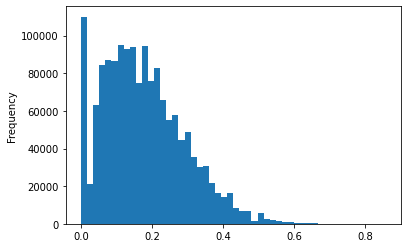

In [ ]:
proxdf.proximity.plot.hist(bins=50)

We observed that proximity is right-skewed. There are a few observations in the right tail with high proximity, which is good: we can cover the informative part without introducing many links.

Load the names of hs code so that we could use for annotation and analysis.

In [ ]:
hsurl = 'http://intl-atlas-downloads.s3.amazonaws.com/17.0/hs_product.zip'
hsdf = pd.read_csv(hsurl,compression='zip',dtype='str')
hsdf.head()

,product_id,hs_product_code,hs_product_name_short_en
0,0,0,Textiles
1,1,1,Agriculture
2,2,2,Stone
3,3,3,Minerals
4,4,4,Metals


Let's only keep the product names used in the calculation of proximity:

In [ ]:
hsdf.hs_product_code.nunique(),proxdf.commoditycode_1.nunique()

(6396, 1240)

In [ ]:
nodedf = hsdf[hsdf.hs_product_code.isin(proxdf.commoditycode_1)][['hs_product_code','hs_product_name_short_en']].sort_values('hs_product_code').reset_index(drop=True)
nodedf.head()

,hs_product_code,hs_product_name_short_en
0,0101,Horses
1,0102,Bovine
2,0103,Swine
3,0104,Sheep
4,0105,Fowl


### (Optional) visualize the raw proximity matrix

If your data is a proximity dataframe, you could transform it into a proxmity matrix using the pandas "pivot" function. The matrix format is sometimes faster for density calculation and other tasks. On the other hand, you could also get a proximity dataframe using pandas "melt" or other functions.

In [ ]:
proxmat = proxdf.pivot(index='commoditycode_1', columns='commoditycode_2',values='proximity').to_numpy()
proxmat.shape

(1240, 1240)

You could visualize the proximity matrix directly using a heatmap. The natural sorting of product codes usually exhibits a block structure.

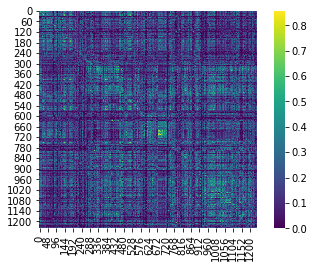

In [ ]:
sns.heatmap(proxmat,cmap='viridis',square=True)

## Create graph and extract the backbone

Given the proximity dataframe or matrix, we could convert them into networkx object. By default, it will create an undirected network. We set the "edge_attr" as **True**, so every other columns in the dataframe are loaded as edge attributes:

In [ ]:
fullgraph = nx.from_pandas_edgelist(proxdf,source='commoditycode_1',target='commoditycode_2',edge_attr=True)
fullgraph.number_of_nodes(),fullgraph.number_of_edges()

(1240, 769420)

Networkx provides the function to generate a minimum/maximum spanning tree, we will generate this using proximity values as the basic skeleton, which makes sure every nodes are connected.

In [ ]:
mst = nx.maximum_spanning_tree(fullgraph,weight='proximity')
mst.number_of_edges()

1239

The next step is to add the more informative high-proximity edges to the mst skeleton. Here it usually need some iterative tweaking of the threshold, so we create a copy of the mst skeleton.

The 2007 paper used a threshold 0.55 for the inclusion of proximity values, and this threshold seems reasonable on the distribution plot, let's try this one:

In [ ]:
vizgraph = mst.copy()
vizgraph.add_edges_from([(u,v,d) for u,v,d in fullgraph.edges(data=True) if d['proximity']>0.55])
vizgraph.number_of_edges()

3107

In [ ]:
nx.density(vizgraph)

0.004044624957692208

The new network seems quite sparse and we should be able to get a meaningful representation rather than the hairball.

## Generate layout of the nodes

Before we jump to the visualization of full network, let's check how the mst skeleton looks.

Here we use the Kamada-Kawai algorithm to generate a layout, which generally works well for smaller networks:

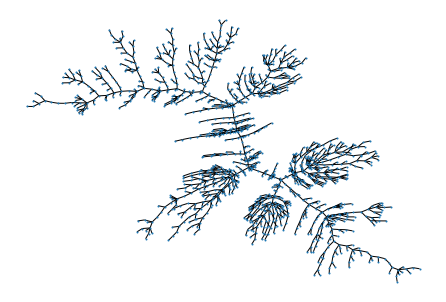

In [ ]:
position = nx.kamada_kawai_layout(mst)
nx.draw(mst,pos=position,node_size=1)

The result already revealed some branches and clusters, we could use this layout as an initial position and speed up the generation of `vizgraph` layout.

In this step, you would probably want to explore different layout algorithms, tune their parameters, and plot them until you get a satisfying position. Sometimes, it may require some manual adjustments before you finalize the layout.

The following is a solution using ForceAtlas2 algorithm (see the [paper](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0098679)), implemented in python as: https://github.com/bhargavchippada/forceatlas2

In [ ]:
from fa2 import ForceAtlas2
position2 = ForceAtlas2(outboundAttractionDistribution=True).forceatlas2_networkx_layout(G=vizgraph, pos=position,iterations=500)

100%|██████████| 500/500 [00:06<00:00, 78.90it/s]

BarnesHut Approximation  took  3.78  seconds
Repulsion forces  took  2.13  seconds
Gravitational forces  took  0.03  seconds
Attraction forces  took  0.03  seconds
AdjustSpeedAndApplyForces step  took  0.13  seconds


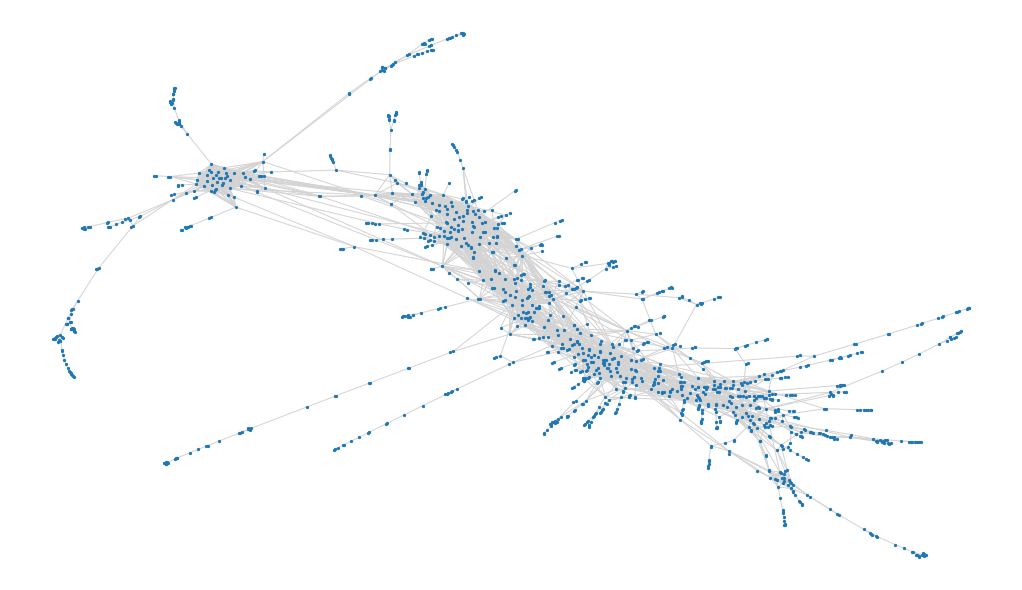

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,pos=position2,node_size=5,edge_color='lightgrey')

The position output is a dictionary, we could create a dataframe and merge it with the nodedf for future use.

In [ ]:
nodedf = nodedf.merge(
    pd.DataFrame.from_dict(position2,orient='index',columns=['x','y']),
    how='left',
    left_on='hs_product_code',
    right_index=True
)
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y
0,0101,Horses,525.648957,168.660470
1,0102,Bovine,-343.203734,738.307063
2,0103,Swine,510.306079,-182.983642
3,0104,Sheep,-660.339515,2057.919070
4,0105,Fowl,-189.134469,203.904952


## Community detection

We would like to extract more meso-scale structural information out of this network representation, one option is to extract the community structure that reveal the block structure we saw in matrix plot.

There are a number of community detection algorithms. The Louvain algorithm is one of the most widely used solution, and the python implementation is here: https://python-louvain.readthedocs.io/en/latest/api.html

In [ ]:
import community as community_louvain
partition = community_louvain.best_partition(vizgraph,weight='proximity',resolution=1,random_state=42)
max(partition.values()) + 1

38

We used the default resolution parameter, and get 38 communities. If you increase the resolution, you will get fewer and larger communities

The `partition` object is a dictionary that sequentially maps each nodes to the community id. We could also merge it to the nodedf dataframe for further analysis.

In [ ]:
nodedf = nodedf.merge(
    pd.DataFrame.from_dict(partition,orient='index',columns=['communityid']),
    how='left',
    left_on='hs_product_code',
    right_index=True
)
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y,communityid
0,0101,Horses,525.648957,168.660470,0
1,0102,Bovine,-343.203734,738.307063,1
2,0103,Swine,510.306079,-182.983642,0
3,0104,Sheep,-660.339515,2057.919070,2
4,0105,Fowl,-189.134469,203.904952,3


Using pandas, we could check the size of each communities:

In [ ]:
nodedf.communityid.value_counts()

15    194
10    151
1     143
3     112
16     72
13     69
6      60
0      56
2      43
8      31
12     29
5      23
21     20
9      20
29     19
4      17
32     16
11     14
19     14
31     13
26     12
36     12
7      11
23     11
17     10
24      9
18      6
14      6
22      6
25      6
28      5
33      5
34      5
37      5
27      4
30      4
35      4
20      3
Name: communityid, dtype: int64

For each community, we could check the included products to understand its meaning.

For example, community 6 is a cluster of garments and textile products

In [ ]:
nodedf.query('communityid == 6').sample(15)

,hs_product_code,hs_product_name_short_en,x,y,communityid
713,6217,Other clothing accesories,-1307.223902,885.422107,6
650,5609,"Articles of yarn, rope etc not elsewhere clasi...",-1378.955925,1128.754960,6
683,6104,"Women's suits, knit",-1467.246747,1172.432453,6
1222,9607,Slide fasteners,-1487.727877,961.257470,6
85,0910,Spices,-1355.638847,1134.351901,6
696,6117,"Other clothing accesories, knit",-1340.129633,983.437776,6
526,4420,"Wood marquetry, ornaments, etc.",-1541.879622,1071.430941,6
685,6106,"Women's shirts, knit",-1386.102827,1179.776832,6
698,6202,"Womens overcoats, not knit",-1388.491297,1099.902895,6
726,6403,Leather footwear,-1283.231241,1062.398449,6


Rearrange the rows and columns in matrix plot, we see a clearer block structure

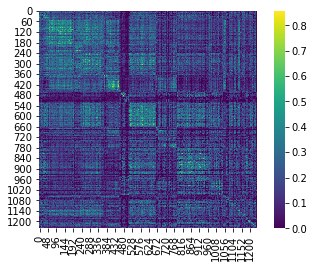

In [ ]:
idx = np.argsort(nodedf.communityid)
proxmat2 = proxmat[:,idx][idx]
sns.heatmap(proxmat2,cmap='viridis',square=True)

## Mapping properties to aesthetic elements

Once we have fixed the position of nodes in the network, the aesthetic elements we could use are mainy the color and size of the nodes. Different shapes of the nodes are not very distinguishable with >1000 nodes, and labels are only usable to annotate few nodes/sectors/communities.

In this section, we will use a saved output from running the py-ecomplexity package on 2015 HS 4-digit trade data:

In [ ]:
df_ec = pd.read_parquet('https://github.com/complexly/summerschool_viz/raw/main/df_ec.parquet')
df_ec.head()

,location_code,hs_product_code,export_value,year,diversity,ubiquity,mcp,eci,pci,density,coi,cog,rca,location_name_short_en,hs_product_name_short_en
0,ABW,0101,0.0,2015,25,20,0,0.214456,0.388663,0.026560,-0.760492,0.311309,0.000000,Aruba,"Horses, asses, mules and hinnies; live"
1,ABW,0102,0.0,2015,25,44,0,0.214456,-0.223360,0.029281,-0.760492,-0.031652,0.000000,Aruba,Bovine animals; live
2,ABW,0103,0.0,2015,25,19,0,0.214456,1.915566,0.020574,-0.760492,0.683068,0.000000,Aruba,Swine; live
3,ABW,0104,0.0,2015,25,24,0,0.214456,-2.384068,0.020903,-0.760492,-0.198515,0.000000,Aruba,Sheep and goats; live
4,ABW,0105,13182.0,2015,25,31,0,0.214456,0.804562,0.025347,-0.760492,0.462749,0.039424,Aruba,"Poultry; live, fowls of the species gallus dom..."


### Color

The color of the nodes are usually used to indicate different categories, such as 2-digit sectors or the communities we discovered above.

A meaningful color map usually require some manual design, such as using brown to represent mining activities and products. Here we would just assign a color to each commmunity from the rainbow color pallette, without further improvement.

In [ ]:
from matplotlib import colors
# use the gist_rainbow colormap
cm = plt.get_cmap('gist_rainbow')
# map each communityid to a color, the output is an rgba array for each node 
colorarray = cm([x/nodedf.communityid.nunique() for x in nodedf.communityid])
# convert the rgba array into a hex string, and store the result into the nodedf dataframe
nodedf['color'] = np.apply_along_axis(colors.to_hex, 1, colorarray)
nodedf.sample(5)

,hs_product_code,hs_product_name_short_en,x,y,communityid,color
534,4701,Mechanical woodpulp,213.049949,-922.499066,32,#6500ff
795,7103,Precious stones,132.313802,-869.083378,34,#b100ff
1160,9022,X-ray machines,931.382356,-934.736696,15,#05ff00
853,7314,Cloth of iron or steel wire,-428.335894,641.522015,1,#ff0009
820,7210,"Flat rolled iron, width > 600mm, clad",206.348306,110.120822,3,#ff4300


Now let's use this color to make a plot. The `node_color` parameter accepts rgba array or hex string for each nodes, which we generated above and already in the correct order.

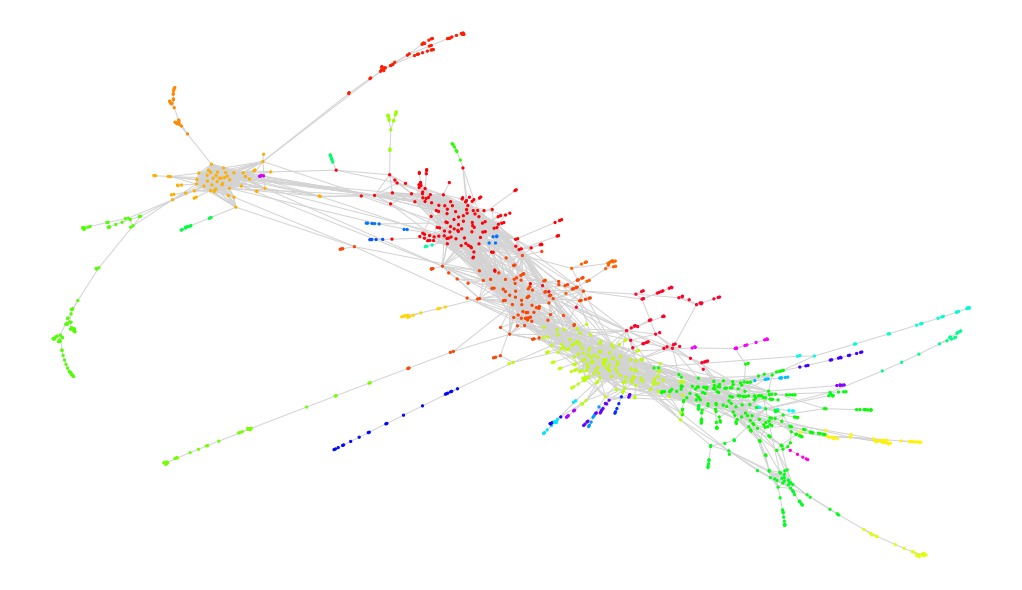

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,pos=position2,node_size=5,node_color=nodedf.color,edge_color='lightgrey')

### Size

We will use the node size to represent the PCI of each product, let's extract the PCI into `nodedf`

In [ ]:
nodedf = nodedf.merge(
    df_ec[['hs_product_code','pci']].drop_duplicates(),
    how='left',
    on='hs_product_code'
)
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y,communityid,color,pci
0,0101,Horses,525.648957,168.660470,0,#ff0029,0.388663
1,0102,Bovine,-343.203734,738.307063,1,#ff0009,-0.223360
2,0103,Swine,510.306079,-182.983642,0,#ff0029,1.915566
3,0104,Sheep,-660.339515,2057.919070,2,#ff1d00,-2.384068
4,0105,Fowl,-189.134469,203.904952,3,#ff4300,0.804562


In [ ]:
nodedf.pci.describe()

count    1239.000000
mean        0.994717
std         1.689723
min        -4.508659
25%        -0.172722
50%         1.088901
75%         2.284902
max         5.489899
Name: pci, dtype: float64

Here we will linearly map the minimum pci product to a size 1, and maximum pci product to a size 100. But you could choose meaningful transformations (e.g. sqrt, log, percentile) to tweak the distribution in your own visualization.

In [ ]:
nodedf['nodesize'] = 1 + (nodedf.pci - nodedf.pci.min())/(nodedf.pci.max() - nodedf.pci.min()) * 99

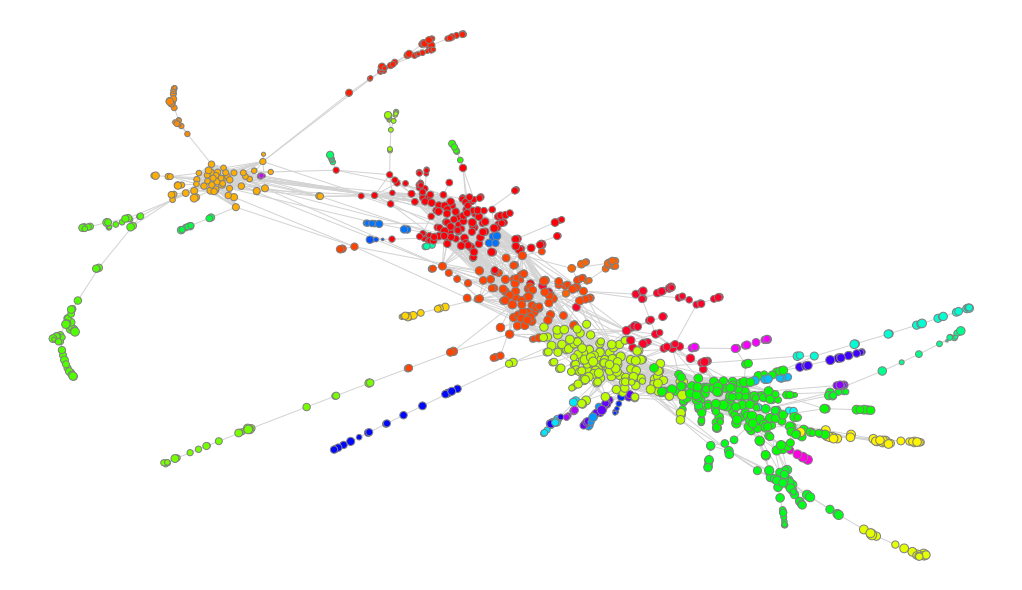

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=nodedf.color,
        edge_color='lightgrey',
        edgecolors='grey')

### Annotation

Sometimes we would like to add some annotations to the product space visualization. Here we will add the communityid to the center of each community.

In [ ]:
df_annotation = nodedf.groupby('communityid')[['x','y']].mean().reset_index()
df_annotation.head()

,communityid,x,y
0,0,537.938960,-60.070902
1,1,-334.840920,794.254369
2,2,-530.705457,2175.383612
3,3,-92.419872,123.306219
4,4,264.214239,376.450002


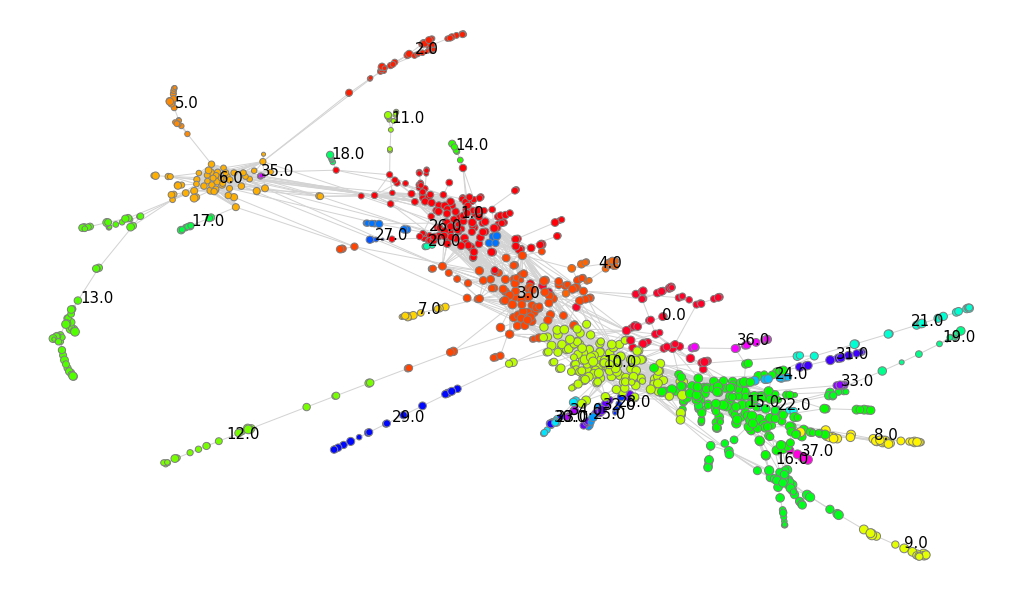

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=nodedf.color,
        edge_color='lightgrey',
        edgecolors='grey')
for i, point in df_annotation.iterrows():
        plt.annotate(point['communityid'],(point['x'], point['y']),fontsize=15)

### Region specific plot

With the full product space, we can highlight the products with RCA>1 for a region. The following shows products where Japan has comparative advantage.

In [ ]:
df_JPN = df_ec[(df_ec.location_code == "JPN") & (df_ec.mcp>0)][['hs_product_code','mcp']]
df_JPN.head()

,hs_product_code,mcp
137082,0307,1
137100,0508,1
137102,0510,1
137186,1505,1
137244,2206,1


We could use the pd.where function and replace the color that doesn't have comparative advantage in Japan with lightgrey.

In [ ]:
jpn_color = nodedf.color.where(
    nodedf.hs_product_code.isin(df_JPN.hs_product_code),
    'lightgrey'
    )

Plot the result for Japan

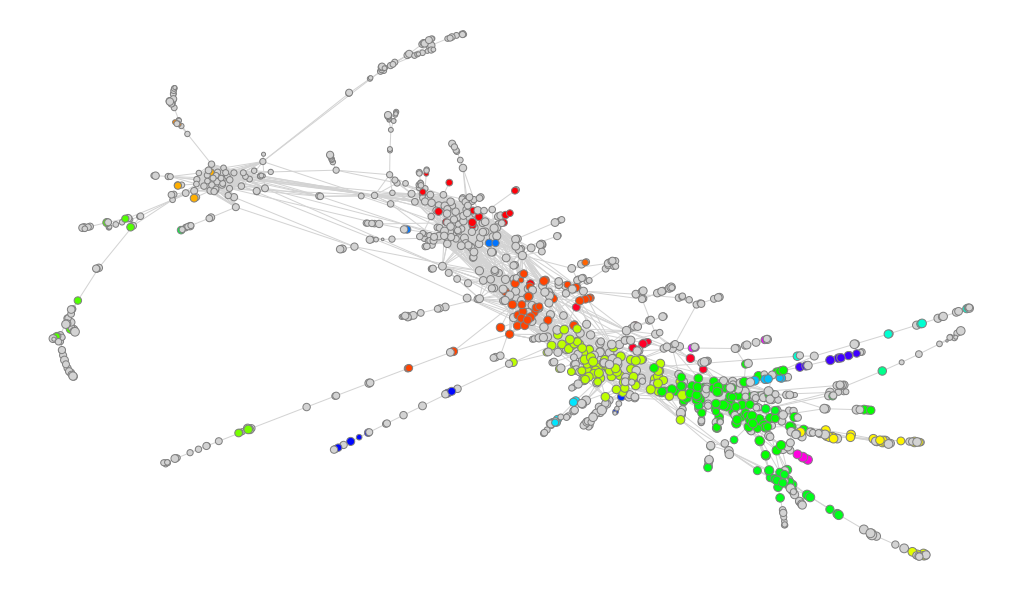

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=jpn_color,
        edge_color='lightgrey',
        edgecolors='grey')

The visualization could be further improved, by adding legends, titles and other annotations. You can refer to the plotting function from Matte and the matplotlib document to create your own plotting infrastructure.

## Save the result for future use

After a series of operations, we finalized the visualization. It's better to save them and prevent repeating the same process.

To save the plotting results, a simple way is to right-click on the figure and download them from your brower. However, a more standard and flexible way is to use the `savefig` function in matplotlib:

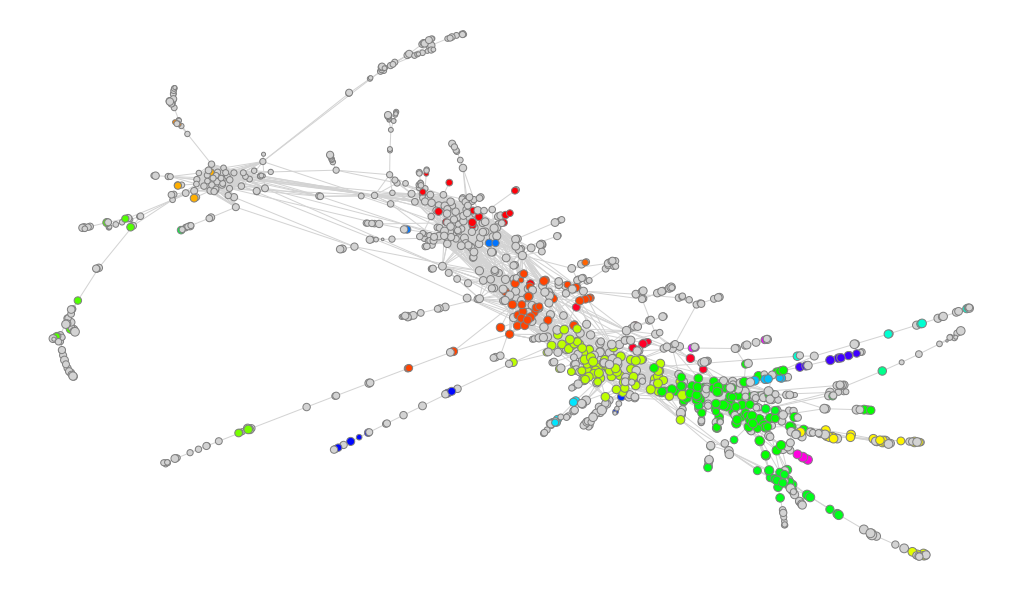

In [ ]:
plt.figure(figsize=(14,8))
nx.draw(vizgraph,
        pos=position2,
        node_size=nodedf.nodesize,
        node_color=jpn_color,
        edge_color='lightgrey',
        edgecolors='grey')
plt.savefig('Japan_2015.png', dpi=300)

Besides the visualization, you may also want to save the networks and node attributes dataframe, which helps you resume the analysis, or conduct analysis in other softwares. For example, saving network into gexf format enables analysis in Gephi for powerful plots

In [ ]:
nx.write_gexf(vizgraph,'vizgraph.gexf')

In [ ]:
nodedf.to_csv('nodedf.tsv',sep='\t',index=False)

In [ ]:
nodedf.head()

,hs_product_code,hs_product_name_short_en,x,y,communityid,color,pci,nodesize
0,0101,Horses,525.648957,168.660470,0,#ff0029,0.388663,49.490475
1,0102,Bovine,-343.203734,738.307063,1,#ff0009,-0.223360,43.430573
2,0103,Swine,510.306079,-182.983642,0,#ff0029,1.915566,64.609000
3,0104,Sheep,-660.339515,2057.919070,2,#ff1d00,-2.384068,22.036480
4,0105,Fowl,-189.134469,203.904952,3,#ff4300,0.804562,53.608468
